In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util_old as pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot


Populating the interactive namespace from numpy and matplotlib


In [36]:
#define functions
def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
    
def process_sample(dir_trail,N=101,out_format='radec'):
    #dir_trail contains all the sample files from the trailing arm
    #convert R,z,phi to ra,dec to xi, eta
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    R_t=[]
    phi_t=[]
    z_t=[]
    vR_t=[]
    vT_t=[]
    vz_t=[]
    t_t=[]

    R_l=[]
    phi_l=[]
    z_l=[]
    vR_l=[]
    vT_l=[]
    vz_l=[]
    t_l=[]
     
    for i in range(N):
        
        try : 
            
            R_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
            phi_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
            z_t.append(numpy.loadtxt(allfname_trail[i])[:,2])
            vR_t.append(numpy.loadtxt(allfname_trail[i])[:,3])
            vT_t.append(numpy.loadtxt(allfname_trail[i])[:,4])
            vz_t.append(numpy.loadtxt(allfname_trail[i])[:,5])
            t_t.append(numpy.loadtxt(allfname_trail[i])[:,6])
            
        except ValueError :
            print (allfname_trail[i])
        
    for ii in range(N):
        
        try :
            
            R_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
            phi_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
            z_l.append(numpy.loadtxt(allfname_lead[ii])[:,2])
            vR_l.append(numpy.loadtxt(allfname_lead[ii])[:,3])
            vT_l.append(numpy.loadtxt(allfname_lead[ii])[:,4])
            vz_l.append(numpy.loadtxt(allfname_lead[ii])[:,5])
            t_l.append(numpy.loadtxt(allfname_lead[ii])[:,6])
            
        except ValueError:
            print (allfname_lead[ii])
        
    Rall_t = np.array([item for sublist in R_t for item in sublist])
    phiall_t = np.array([item for sublist in phi_t for item in sublist])
    zall_t = np.array([item for sublist in z_t for item in sublist])
    vRall_t = np.array([item for sublist in vR_t for item in sublist])
    vTall_t = np.array([item for sublist in vT_t for item in sublist])
    vzall_t = np.array([item for sublist in vz_t for item in sublist])
    tall_t = np.array([item for sublist in t_t for item in sublist])

    Rall_l = np.array([item for sublist in R_l for item in sublist])
    phiall_l = np.array([item for sublist in phi_l for item in sublist])
    zall_l = np.array([item for sublist in z_l for item in sublist])
    vRall_l = np.array([item for sublist in vR_l for item in sublist])
    vTall_l = np.array([item for sublist in vT_l for item in sublist])
    vzall_l = np.array([item for sublist in vz_l for item in sublist])
    tall_l = np.array([item for sublist in t_l for item in sublist])
    
    x_l,y_l,z_l=bovy_coords.cyl_to_rect(Rall_l,phiall_l,zall_l)
    
    l_t,b_t,d_t=np.array(galcencyl_to_lbd(Rall_t,phiall_t,zall_t))
    l_l,b_l,d_l=np.array(galcencyl_to_lbd(Rall_l,phiall_l,zall_l))
    
    radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
    radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True)
    
    o_t=[]
    ts_t=[]
    o_l=[]
    ts_l=[]
    
   
    if out_format=='radec' :
        return (radec_t[:,0],radec_t[:,1],radec_l[:,0],radec_l[:,1])
    
    elif out_format=='xieta':
        
        mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
        xi_t= mxieta_t[:,0]
        eta_t=mxieta_t[:,1]

        mxieta_l= pal5_util.radec_to_pal5xieta(radec_l[:,0],radec_l[:,1],degree=True)
        xi_l= mxieta_l[:,0]
        eta_l=mxieta_l[:,1]
    
        return (xi_t,eta_t,xi_l,eta_l)
        
        
    else : 
        print ("acceptable output format : radec or xieta")

        
        
def include_both_arms(xi_t,eta_t,xi_l,eta_l):
    min_eta_t=min(eta_t)
    max_eta_t=max(eta_t)

    xi_l_select=[]
    eta_l_select=[]

    for jj in range(len(eta_l)):
        if min_eta_t <= eta_l[jj] <= max_eta_t :
            xi_l_select.append(xi_l[jj])
            eta_l_select.append(eta_l[jj])

    print (len(xi_l), len(xi_l_select))

    #plt.figure()
    #plt.scatter(xi_l_select,eta_l_select)
    #plt.show()
    
    xi_all = np.concatenate((xi_t,xi_l_select))
    
    return xi_all

def compute_length(Ndn,sNdn,midxi,max_midxi=3.,minxi=0.65,maxxi=14.35,frac=0.2):
    
       
    sNdn_select = []
    for jj in range(len(midxi)):
        if midxi[jj] < max_midxi :
            sNdn_select.append(sNdn[jj])
        
    sNdn_select=np.array(sNdn_select)
    mean_Ndn=np.mean(sNdn_select)

    ind=[]
    for ii in range(len(midxi)):
        #print (Ndn[ii],0.2*sNdn[ii])
        if Ndn[ii]<= mean_Ndn*frac:
            
            ind.append(ii)
    
    if len(ind) != 0 :
        maxxi=midxi[min(ind)]
    
    return maxxi-minxi


def compute_SNdnxi(xi,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3):
    N=len(xi)
    print (N)
    
    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(xi,xibin_edge)[0]
    print (np.sum(Ndn))
               
    return (midxi,Ndn)
        

def compute_Ndnxi(xi,sNdn,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,plot=True,ylim_max=1500.,label='',fname=''):
    N=len(xi)
    print (N)
    
    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(xi,xibin_edge)[0]
    print (np.sum(Ndn))
    length=compute_length(Ndn,sNdn,midxi,max_midxi=3.,minxi=0.25,maxxi=14.35,frac=0.2)
           
    if plot :
            plt.figure(figsize=(20,10))
            plt.title('stream length = %.1f deg'%length)
            plt.plot(midxi,Ndn,ls='steps-mid',label=label)
            plt.ylim(0.,ylim_max)
            plt.xlabel(r'$\xi$ (deg)',fontsize=18)
            plt.ylabel('Star count',fontsize=18)
            plt.legend(loc='upper right',fontsize=18)
               
            if fname != '' :
                plt.savefig(fname)
            
            plt.show()
            
    return (midxi,Ndn,length)


## Smooth stream

In [43]:
Om=[35,37,39,40,41,43,45,47,49,50,51,53,55,57,59,61]
#39,43,47,51,57,59,61
method=['spraydf','spraydf_noprog']
M_str='1010'


streamdf_609=[]
streamdf_809=[]
streamdf_1010=[]
streamdf_1210=[]
streamdf_1410=[]

spraydf_609=[]
spraydf_809=[]
spraydf_1010=[]
spraydf_1210=[]
spraydf_1410=[]

spraydf_noprog_609=[]
spraydf_noprog_809=[]
spraydf_noprog_1010=[]
spraydf_noprog_1210=[]
spraydf_noprog_1410=[]


   
for m in method : 
    
    stream_length = []

    for om in Om :
        
        m_s=m.replace('_noprog','')

        dir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/{}Msun_{}_nobarpot/trailing/'.format(M_str,m_s)
        sxi_t,seta_t,sxi_l,seta_l=process_sample(dir_trail=dir,out_format='xieta')

        sxi = include_both_arms(sxi_t,seta_t,sxi_l,seta_l)
        
        sxi=sxi[:50500]

        smidxi,sNdn = compute_SNdnxi(sxi,minxi=0.65,maxxi=14.35,bw=0.1)

        #plt.figure()
        #plt.scatter(sxi_t,seta_t,s=1,c='r',label='trailing',rasterized=True)
        #plt.scatter(sxi_l,seta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
        #plt.xlabel(r'$\xi$ (deg)')
        #plt.ylabel(r'$\eta$ (deg)')
        #plt.show()

    #
    


    
        #dir1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'+M_str+'Msun_5Gyr_'+method+'_patspeed{}'.format(om)+'/trailing/'
        dir1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'+M_str+'Msun_{}patspeed_'.format(om)+m+'/trailing/'
        print (dir1)

        xi_t,eta_t,xi_l,eta_l=process_sample(dir1,out_format='xieta')

        #plt.figure()
        #plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
        #plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
        #plt.xlabel(r'$\xi$ (deg)')
        #plt.ylabel(r'$\eta$ (deg)')

        xi=include_both_arms(xi_t,eta_t,xi_l,eta_l)
        xi=xi[:50500]
        
        #print (len(xi))

        midxi,Ndn,length = compute_Ndnxi(xi,sNdn,minxi=0.65,maxxi=14.35,bw=0.1,ylim_max=1500.,plot=False,label= m+ ' 5Gyr {} km/s/kpc'.format(om),
                                            fname='plots/50k_nden_'+M_str+m+'_5Gyr_patspeed{}.pdf'.format(om))

        stream_length.append(length)
        
    print (m,stream_length)


101000 98388
50500
no of xi bins = 136
38365
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_35patspeed_spraydf/trailing/
101000 95726
50500
no of xi bins = 136
30292
101000 98388
50500
no of xi bins = 136
38365
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_37patspeed_spraydf/trailing/
101000 99542
50500
no of xi bins = 136
37822
101000 98388
50500
no of xi bins = 136
38365
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_39patspeed_spraydf/trailing/
101000 100031
50500
no of xi bins = 136
42408
101000 98388
50500
no of xi bins = 136
38365
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_40patspeed_spraydf/trailing/
101000 100385
50500
no of xi bins = 136
45099
101000 98388
50500
no of xi bins = 136
38365
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_41patspeed_spraydf/trailing/
101000 98454
50500
no of xi bins = 136
38480
101000 98388
50500
no of xi bins = 136
38365
/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_43pa

## $M_{\rm{bar}} = 6\times 10^{9} \rm{M}_{\odot}$

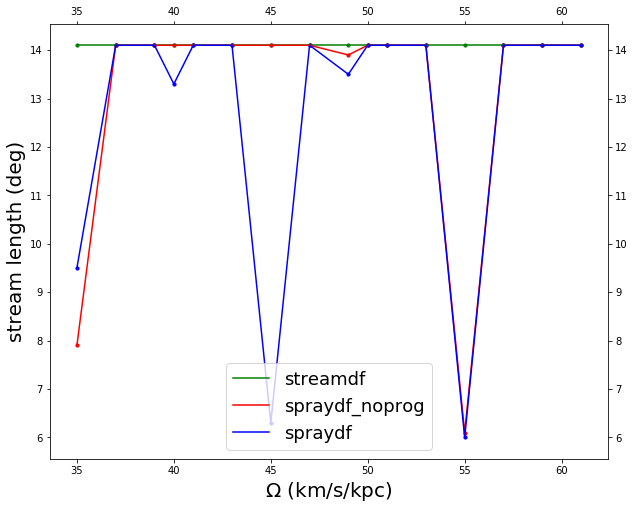

In [16]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.,57.,59.,61.]

streamdf=[14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1,14.1,14.1,14.1]
spraydf_noprog = [7.9, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 13.9, 14.1, 14.1, 14.1, 6.1, 14.1, 14.1, 14.1]
spraydf= [9.5, 14.1, 14.1, 13.3, 14.1, 14.1, 6.3, 14.1, 13.5, 14.1, 14.1, 14.1, 6.0, 14.1, 14.1, 14.1]

plt.figure(figsize=(10,8))
plt.plot(pat_speed,streamdf,c='g',label='streamdf')
plt.plot(pat_speed,spraydf_noprog,c='r',label='spraydf_noprog')
plt.plot(pat_speed,spraydf,c='b',label='spraydf')

plt.scatter(pat_speed,streamdf,s=10,c='g')
plt.scatter(pat_speed,spraydf_noprog,s=10,c='r')
plt.scatter(pat_speed,spraydf,s=10,c='b')
plt.legend(loc='lower center',fontsize=18)
tick_params(labeltop=True, labelright=True,axis='both',top=True,right=True,grid_color=True)

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=20)
plt.ylabel(r'stream length (deg)',fontsize=20)
plt.savefig('plots/'+M_str+'_stream_length_vs_pat_speed.pdf')
plt.show()




## $M_{\rm{bar}} = 8\times 10^{9} \rm{M}_{\odot}$

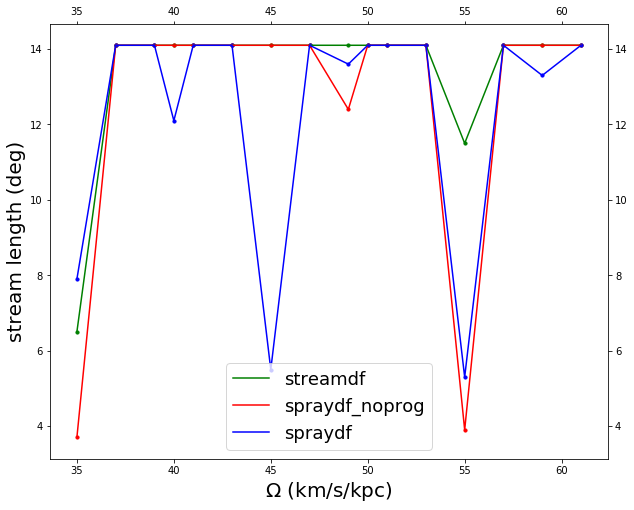

In [18]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.,57.,59.,61.]

streamdf=[6.5, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 11.5, 14.1, 14.1, 14.1]
spraydf_noprog = [3.7, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 12.4, 14.1, 14.1, 14.1, 3.9, 14.1, 14.1, 14.1]
spraydf= [7.9, 14.1, 14.1, 12.1, 14.1, 14.1, 5.5, 14.1, 13.6, 14.1, 14.1, 14.1, 5.3, 14.1, 13.3, 14.1]

plt.figure(figsize=(10,8))
plt.plot(pat_speed,streamdf,c='g',label='streamdf')
plt.plot(pat_speed,spraydf_noprog,c='r',label='spraydf_noprog')
plt.plot(pat_speed,spraydf,c='b',label='spraydf')

plt.scatter(pat_speed,streamdf,s=10,c='g')
plt.scatter(pat_speed,spraydf_noprog,s=10,c='r')
plt.scatter(pat_speed,spraydf,s=10,c='b')
plt.legend(loc='lower center',fontsize=18)
tick_params(labeltop=True, labelright=True,axis='both',top=True,right=True,grid_color=True)

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=20)
plt.ylabel(r'stream length (deg)',fontsize=20)
plt.savefig('plots/'+M_str+'_stream_length_vs_pat_speed.pdf')
plt.show()




## $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$

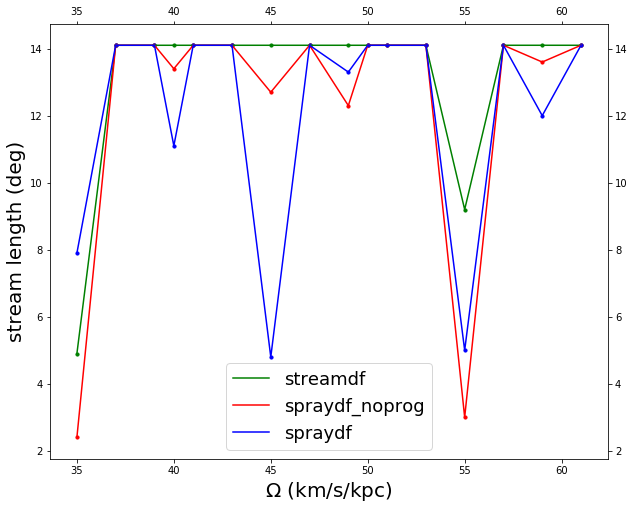

In [44]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.,57.,59.,61.]

streamdf=[4.9, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 9.2, 14.1, 14.1, 14.1]
spraydf_noprog = [2.4, 14.1, 14.1, 13.4, 14.1, 14.1, 12.7, 14.1, 12.3, 14.1, 14.1, 14.1, 3.0, 14.1, 13.6, 14.1]
spraydf= [7.9, 14.1, 14.1, 11.1, 14.1, 14.1, 4.8, 14.1, 13.3, 14.1, 14.1, 14.1, 5.0, 14.1, 12.0, 14.1]

plt.figure(figsize=(10,8))
plt.plot(pat_speed,streamdf,c='g',label='streamdf')
plt.plot(pat_speed,spraydf_noprog,c='r',label='spraydf_noprog')
plt.plot(pat_speed,spraydf,c='b',label='spraydf')

plt.scatter(pat_speed,streamdf,s=10,c='g')
plt.scatter(pat_speed,spraydf_noprog,s=10,c='r')
plt.scatter(pat_speed,spraydf,s=10,c='b')
plt.legend(loc='lower center',fontsize=18)
tick_params(labeltop=True, labelright=True,axis='both',top=True,right=True,grid_color=True)

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=20)
plt.ylabel(r'stream length (deg)',fontsize=20)
plt.savefig('plots/'+M_str+'_stream_length_vs_pat_speed.pdf')
plt.show()




## $M_{\rm{bar}} = 1.2\times 10^{10} \rm{M}_{\odot}$

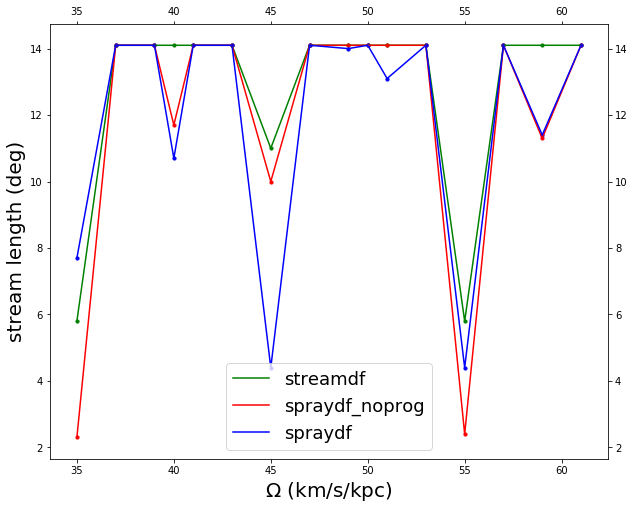

In [23]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.,57.,59.,61.]

streamdf=[5.8, 14.1, 14.1, 14.1, 14.1, 14.1, 11.0, 14.1, 14.1, 14.1, 14.1, 14.1, 5.8, 14.1, 14.1, 14.1]
spraydf_noprog = [2.3, 14.1, 14.1, 11.7, 14.1, 14.1, 10.0, 14.1, 14.1, 14.1, 14.1, 14.1, 2.4, 14.1, 11.3, 14.1]
spraydf= [7.7, 14.1, 14.1, 10.7, 14.1, 14.1, 4.4, 14.1, 14.0, 14.1, 13.1, 14.1, 4.4, 14.1, 11.4, 14.1]

plt.figure(figsize=(10,8))
plt.plot(pat_speed,streamdf,c='g',label='streamdf')
plt.plot(pat_speed,spraydf_noprog,c='r',label='spraydf_noprog')
plt.plot(pat_speed,spraydf,c='b',label='spraydf')

plt.scatter(pat_speed,streamdf,s=10,c='g')
plt.scatter(pat_speed,spraydf_noprog,s=10,c='r')
plt.scatter(pat_speed,spraydf,s=10,c='b')
plt.legend(loc='lower center',fontsize=18)
tick_params(labeltop=True, labelright=True,axis='both',top=True,right=True,grid_color=True)

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=20)
plt.ylabel(r'stream length (deg)',fontsize=20)
plt.savefig('plots/'+M_str+'_stream_length_vs_pat_speed.pdf')
plt.show()




## $M_{\rm{bar}} = 1.4\times 10^{10} \rm{M}_{\odot}$

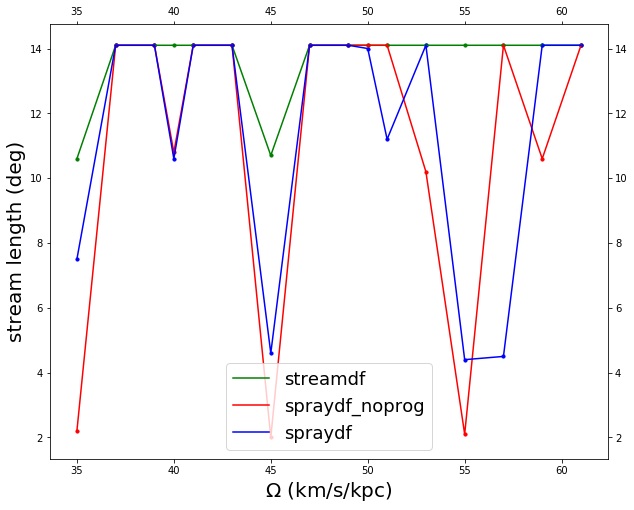

In [25]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.,57.,59.,61.]



streamdf=[10.6, 14.1, 14.1, 14.1, 14.1, 14.1, 10.7, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1]
spraydf_noprog = [2.2, 14.1, 14.1, 10.8, 14.1, 14.1, 2.0, 14.1, 14.1, 14.1, 14.1, 10.2, 2.1, 14.1, 10.6, 14.1]
spraydf= [7.5, 14.1, 14.1, 10.6, 14.1, 14.1, 4.6, 14.1, 14.1, 14.0, 11.2, 14.1, 4.4, 4.5, 14.1, 14.1]

plt.figure(figsize=(10,8))
plt.plot(pat_speed,streamdf,c='g',label='streamdf')
plt.plot(pat_speed,spraydf_noprog,c='r',label='spraydf_noprog')
plt.plot(pat_speed,spraydf,c='b',label='spraydf')

plt.scatter(pat_speed,streamdf,s=10,c='g')
plt.scatter(pat_speed,spraydf_noprog,s=10,c='r')
plt.scatter(pat_speed,spraydf,s=10,c='b')
plt.legend(loc='lower center',fontsize=18)
tick_params(labeltop=True, labelright=True,axis='both',top=True,right=True,grid_color=True)

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=20)
plt.ylabel(r'stream length (deg)',fontsize=20)
plt.savefig('plots/'+M_str+'_stream_length_vs_pat_speed.pdf')
plt.show()




In [62]:
def color_from_colormap(val,cmap,cmin,cmax):
    return cmap((val-cmin)/(cmax-cmin))
def add_colorbar_dens(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel,size=18)
    return None
def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel,weight='bold',size=18)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel,weight='bold')
    return None

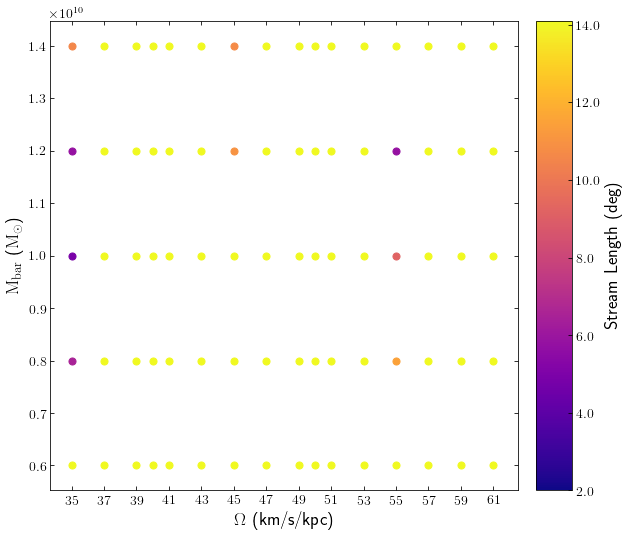

In [70]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.,57.,59.,61.]

M=[6*10**9,8*10**9,10**10,1.2*10**10,1.4*10**10]

streamdf_609=[14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1,14.1,14.1,14.1]
streamdf_809=[6.5, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 11.5, 14.1, 14.1, 14.1]
streamdf_1010=[4.9, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 9.2, 14.1, 14.1, 14.1]
streamdf_1210=[5.8, 14.1, 14.1, 14.1, 14.1, 14.1, 11.0, 14.1, 14.1, 14.1, 14.1, 14.1, 5.8, 14.1, 14.1, 14.1]
streamdf_1410=[10.6, 14.1, 14.1, 14.1, 14.1, 14.1, 10.7, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1]

cmap= cm.plasma



#plt.figure()
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(10.,8.)
fig= figure()
fig.subplots_adjust(left=0.1,right=0.75,bottom=0.135,top=0.95,wspace=0.075)
#title(r'$(\Omega,\theta)$',fontsize=18)

for ii in range(len(pat_speed)):
    plt.scatter(pat_speed[ii],M[0],s=50,color=color_from_colormap(streamdf_609[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[1],s=50,color=color_from_colormap(streamdf_809[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[2],s=50,color=color_from_colormap(streamdf_1010[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[3],s=50,color=color_from_colormap(streamdf_1210[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[4],s=50,color=color_from_colormap(streamdf_1410[ii],cmap,2.,14.1))

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=18)
plt.ylabel(r'$\rm{M}_{\rm{bar}}$ ($\rm{M}_{\odot}$)',fontsize=18)
plt.xticks(np.arange(35,62,2))
add_colorbar_dens(2.,14.1,r'Stream Length (deg)',save_figures=True)
savefig('plots/streamdf_omega_Mbar.pdf')


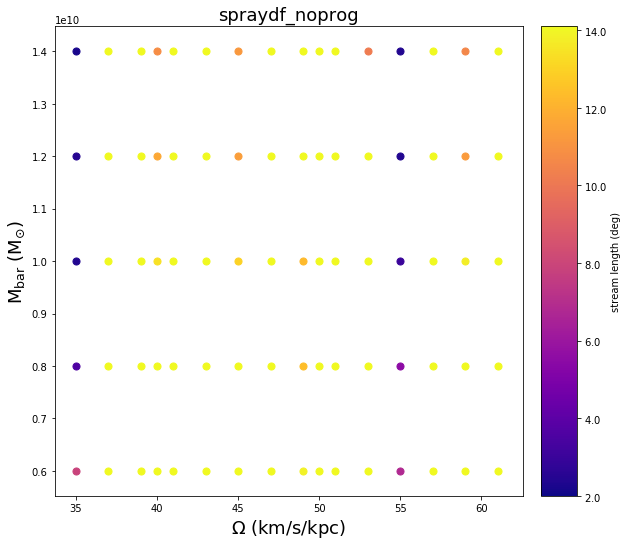

In [58]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.,57,59,61]

M=[6*10**9,8*10**9,10**10,1.2*10**10,1.4*10**10]

spraydf_noprog_609 = [7.9, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 13.9, 14.1, 14.1, 14.1, 6.8,14.1,14.1,14.1]
spraydf_noprog_809 = [3.6, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 14.1, 12.4, 14.1, 14.1, 14.1, 5.5,14.1, 14.1, 14.1]
spraydf_noprog_1010 = [2.4, 14.1, 14.1, 13.4, 14.1, 14.1, 13.0, 14.1, 12.3, 14.1, 14.1, 14.1, 3.0,14.1, 13.8, 14.1]
spraydf_noprog_1210 = [2.5, 14.1, 14.1, 11.7, 14.1, 14.1, 11.4, 14.1, 14.1, 14.1, 14.1, 14.1, 2.4,14.1, 11.3, 14.1]
spraydf_noprog_1410 = [2.2, 14.1, 14.1, 10.8, 14.1, 14.1, 11.2, 14.1, 14.1, 14.1, 14.1, 10.2, 2.4,14.1, 10.6, 14.1]


cmap= cm.plasma



#plt.figure()

figsize(10.,8.)
fig= figure()
fig.subplots_adjust(left=0.1,right=0.75,bottom=0.135,top=0.95,wspace=0.075)
title('spraydf_noprog',fontsize=18)

for ii in range(len(pat_speed)):
    plt.scatter(pat_speed[ii],M[0],s=50,color=color_from_colormap(spraydf_noprog_609[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[1],s=50,color=color_from_colormap(spraydf_noprog_809[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[2],s=50,color=color_from_colormap(spraydf_noprog_1010[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[3],s=50,color=color_from_colormap(spraydf_noprog_1210[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[4],s=50,color=color_from_colormap(spraydf_noprog_1410[ii],cmap,2.,14.1))

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=18)
plt.ylabel(r'$\rm{M}_{\rm{bar}}$ ($\rm{M}_{\odot}$)',fontsize=18)
add_colorbar_dens(2.,14.1,r'stream length (deg)',save_figures=True)
savefig('plots/spraydf_noprog_omega_Mbar.pdf')


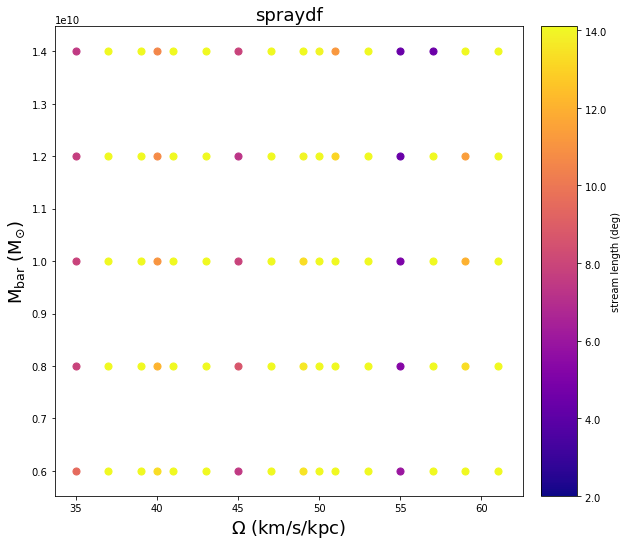

In [59]:
pat_speed=[35.,37.,39.,40.,41.,43.,45.,47.,49.,50.,51.,53.,55.,57,59,61]

M=[6*10**9,8*10**9,10**10,1.2*10**10,1.4*10**10]


spraydf_609= [9.5, 14.1, 14.1, 13.3, 14.1, 14.1, 7.5, 14.1, 13.5, 14.1, 14.1, 14.1, 6.0,14.1,14.1,14.1]
spraydf_809= [7.9, 14.1, 14.1, 12.1, 14.1, 14.1, 8.7, 14.1, 13.6, 14.1, 14.1, 14.1, 5.3,14.1, 13.3, 14.1]
spraydf_1010= [7.9, 14.1, 14.1, 11.1, 14.1, 14.1, 7.9, 14.1, 13.3, 14.1, 14.1, 14.1, 5.0,14.1, 12.0, 14.1]
spraydf_1210= [7.7, 14.1, 14.1, 10.7, 14.1, 14.1, 7.3, 14.1, 14.0, 14.1, 13.1, 14.1, 4.4,14.1, 11.4, 14.1]
spraydf_1410= [7.5, 14.1, 14.1, 10.6, 14.1, 14.1, 7.9, 14.1, 14.1, 14.0, 11.2, 14.1, 4.4,4.5, 14.1, 14.1]

cmap= cm.plasma



#plt.figure()

figsize(10.,8.)
fig= figure()
fig.subplots_adjust(left=0.1,right=0.75,bottom=0.135,top=0.95,wspace=0.075)
title('spraydf',fontsize=18)

for ii in range(len(pat_speed)):
    plt.scatter(pat_speed[ii],M[0],s=50,color=color_from_colormap(spraydf_609[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[1],s=50,color=color_from_colormap(spraydf_809[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[2],s=50,color=color_from_colormap(spraydf_1010[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[3],s=50,color=color_from_colormap(spraydf_1210[ii],cmap,2.,14.1))
    plt.scatter(pat_speed[ii],M[4],s=50,color=color_from_colormap(spraydf_1410[ii],cmap,2.,14.1))

plt.xlabel(r'$\Omega$ (km/s/kpc)',fontsize=18)
plt.ylabel(r'$\rm{M}_{\rm{bar}}$ ($\rm{M}_{\odot}$)',fontsize=18)
add_colorbar_dens(2.,14.1,r'stream length (deg)',save_figures=True)
savefig('plots/spraydf_omega_Mbar.pdf')